### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell


In [176]:
import torch
import mubind as mb
import scanpy as sc

In [177]:

# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

noack_2022_use_logdynamic_0.pth
noack_2022_use_logdynamic_1.pth


In [178]:
ad = sc.read_h5ad('noack_2022_sample_train.h5ad')
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [179]:
rna_sample.shape

(276, 497)

In [180]:
import pickle
train = pickle.load(open('train_dataloader.pkl', 'rb'))

In [181]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [182]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [183]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [184]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [185]:
import matplotlib.pyplot as plt

False
True
3
order None
0 out of 288...
break


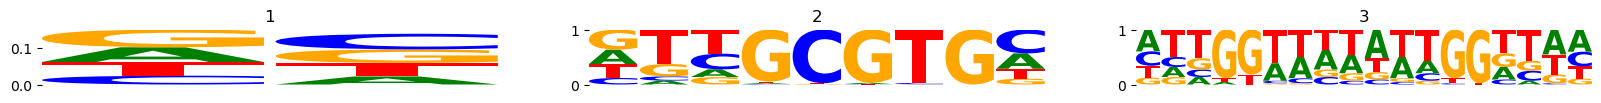

True
True
3
order None
0 out of 288...
break


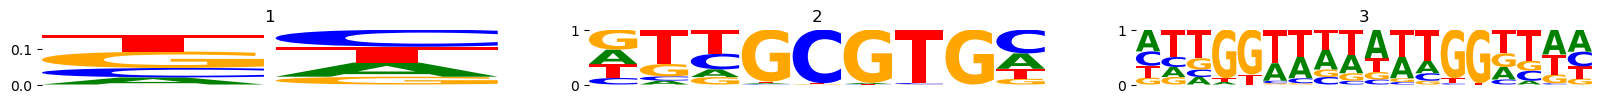

In [186]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


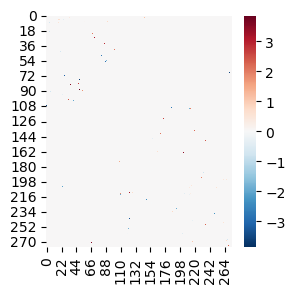

In [187]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [188]:
model = model_by_logdynamic[1]

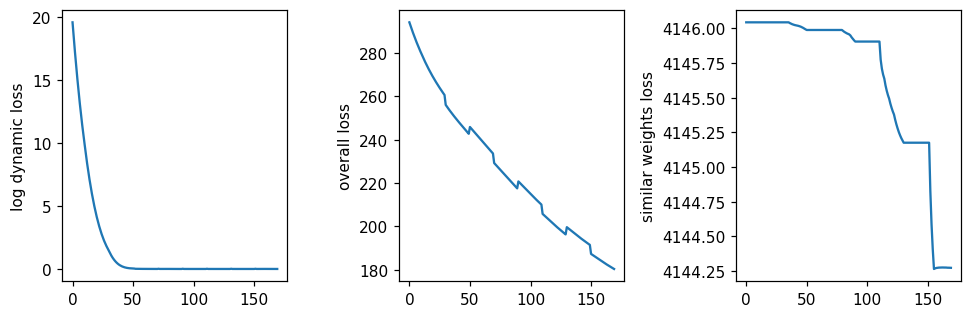

In [189]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [190]:
import pandas as pd
import numpy as np

False
True


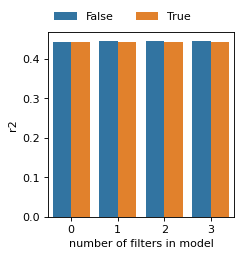

In [191]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

In [192]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [193]:
ad.obs['dynamic_score'].describe()

count    276.000000
mean       0.536116
std        0.129414
min        0.000000
25%        0.535871
50%        0.536116
75%        0.536449
max        1.000000
Name: dynamic_score, dtype: float64

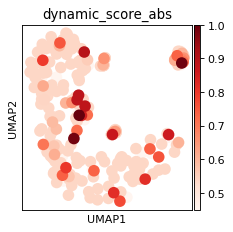

In [194]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

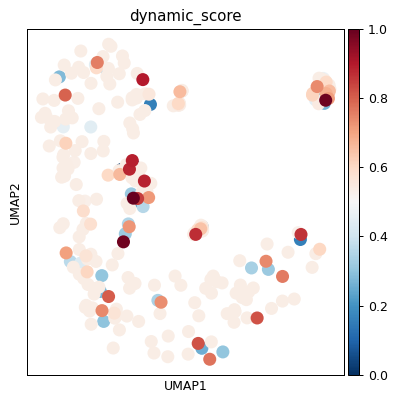

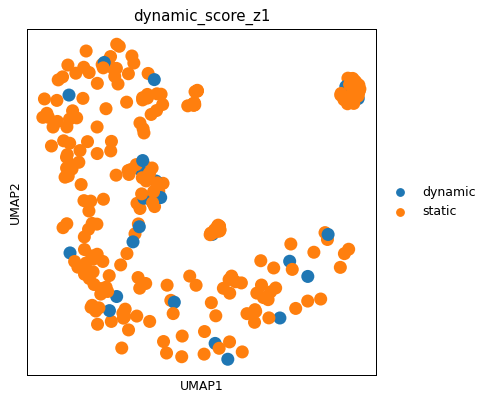

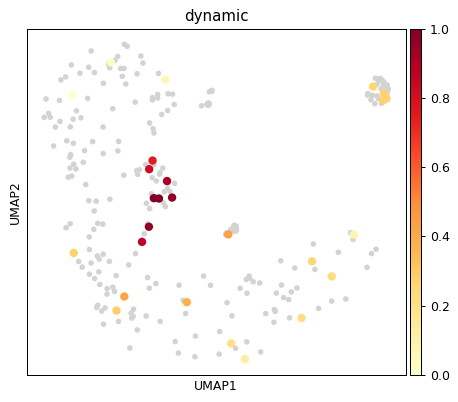

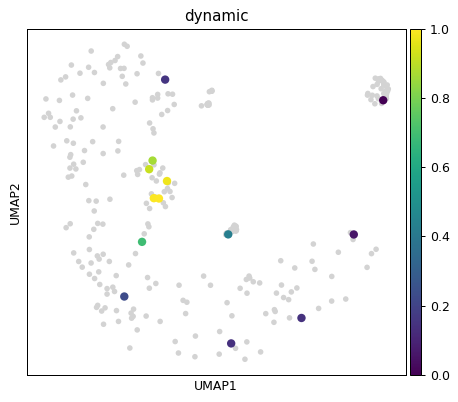

In [195]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

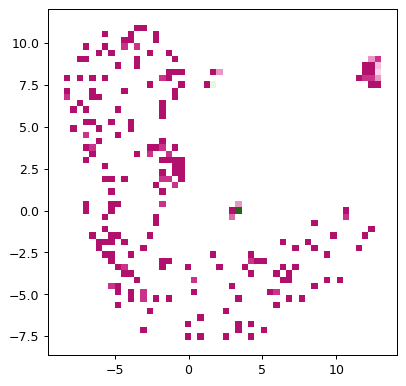

In [196]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

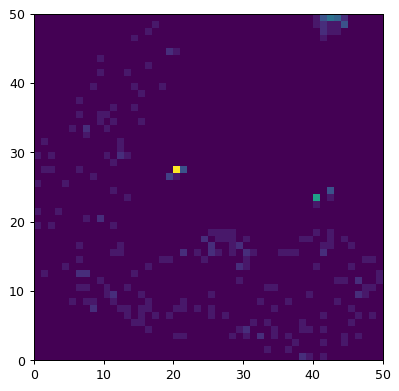

In [197]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [198]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [199]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


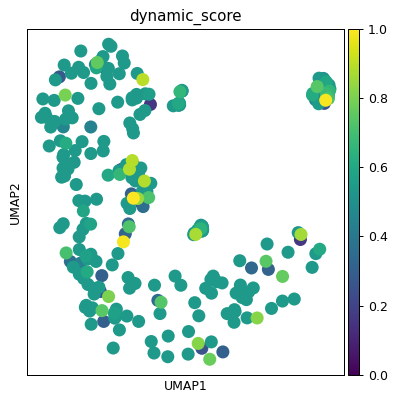

In [200]:
sc.pl.umap(ad, color='dynamic_score')

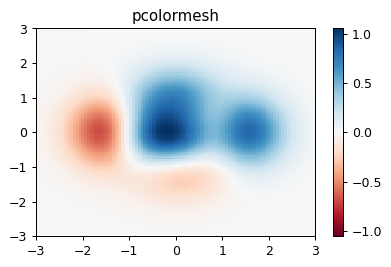

In [201]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [202]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [203]:
cell_type_key = 'clusters'

In [204]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

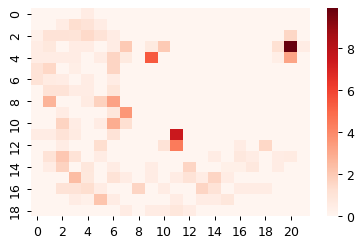

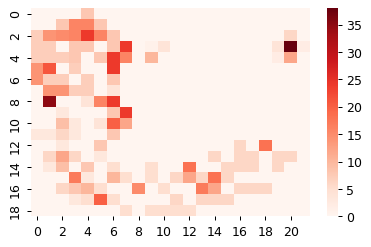

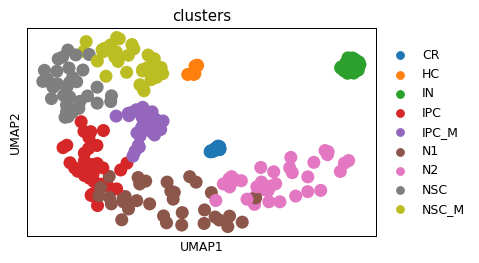

In [205]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [206]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [207]:
model = model_by_logdynamic[True]

In [208]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [209]:
# number of non_zero weights
len(G[G != 0])

592

In [210]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [211]:
print('here...')

here...


In [212]:
ad

AnnData object with n_obs × n_vars = 276 × 497
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'tss_start', 'tss_end', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
    uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dyn

In [213]:
model = model.cuda()

In [214]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [215]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(497, 276)
744908800000.0


In [216]:
import scvelo as scv

In [217]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [218]:
np.random.shuffle(binding_scores)
binding_scores

array([[ 3971566.5,  4811895.5, 10255978. , ...,  5467366.5,  5436198.5,
         4769423.5],
       [ 4010666.5,  4875103. , 10458931. , ...,  5571081. ,  5511137.5,
         4844853. ],
       [ 4026298. ,  4894559. , 10537752. , ...,  5611079. ,  5540759.5,
         4871834.5],
       ...,
       [ 3855645.2,  4662329. ,  9780687. , ...,  5334949. ,  5266796.5,
         4633005.5],
       [ 4026298. ,  4894559. , 10537752. , ...,  5611079. ,  5540759.5,
         4871834.5],
       [ 4026298. ,  4894559. , 10537752. , ...,  5611079. ,  5540759.5,
         4871834.5]], dtype=float32)

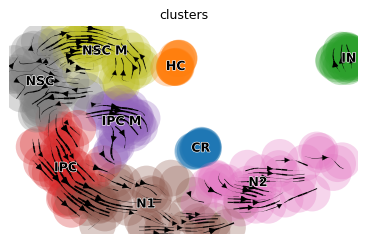

In [219]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [220]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

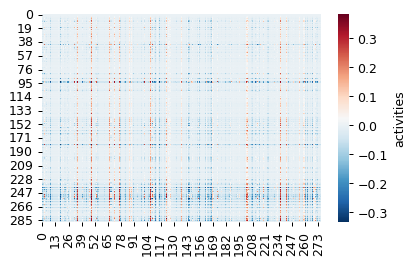

In [221]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

In [222]:
rna_sample.layers['velocity'].shape, rna_sample.shape

((276, 497), (276, 497))

In [223]:
# scv.pl.velocity_graph(rna_sample)

In [224]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [225]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [226]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [227]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 276 × 497
     obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'tss_start', 'tss_end', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
     uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover

In [228]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(276, 497)

In [229]:
pwd

'/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell'

In [230]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [231]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


False


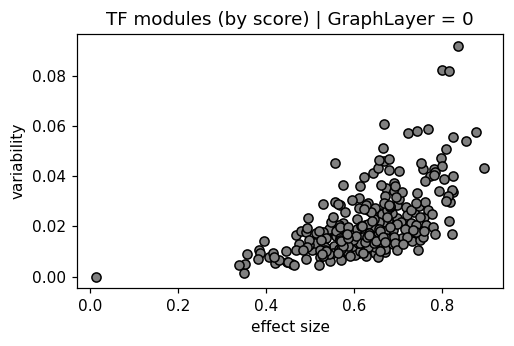

True


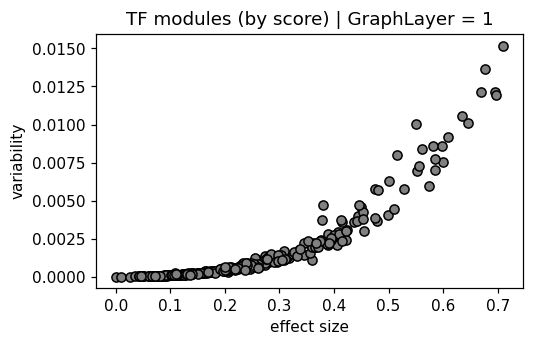

In [232]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [233]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


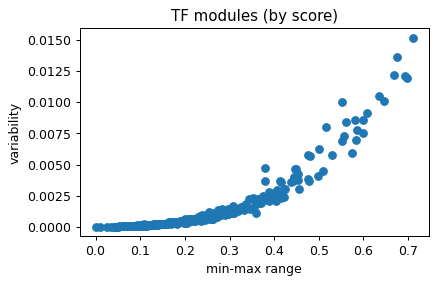

In [234]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [235]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [236]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

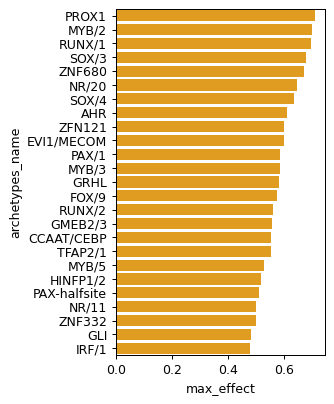

In [237]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [238]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed
106,True,105,0.313872,1.004202e-07,0.196194,0.000478,105,PRDM1,PRDM1_C2H2_1
41,True,40,0.298094,4.535519e-07,0.500472,0.006254,40,NR/11,ERR2_MOUSE.H11MO.0.A
53,True,52,0.272687,4.284647e-06,0.552152,0.006926,52,CCAAT/CEBP,CEBPA_HUMAN.H11MO.0.A
249,True,248,0.260048,1.207933e-05,0.645042,0.010080,248,NR/20,ANDR_MOUSE.H11MO.0.A
265,True,264,0.258303,1.388011e-05,0.550884,0.010062,264,TFAP2/1,AP2A_HUMAN.H11MO.0.A
...,...,...,...,...,...,...,...,...,...
247,True,246,0.002459,9.675663e-01,0.248620,0.000737,246,RFX/3,RFX5_HUMAN.H11MO.0.A
6,True,5,-0.002130,9.719056e-01,0.139109,0.000187,5,HD/5,BARX1_homeodomain_1
167,True,166,0.002012,9.734573e-01,0.248003,0.000792,166,TEAD,TEAD1_HUMAN.H11MO.0.A
67,True,66,0.001538,9.797054e-01,0.060692,0.000032,66,SCRT1,SCRT1_C2H2_1


True
1
order None
0 out of 288...
10 out of 288...
break


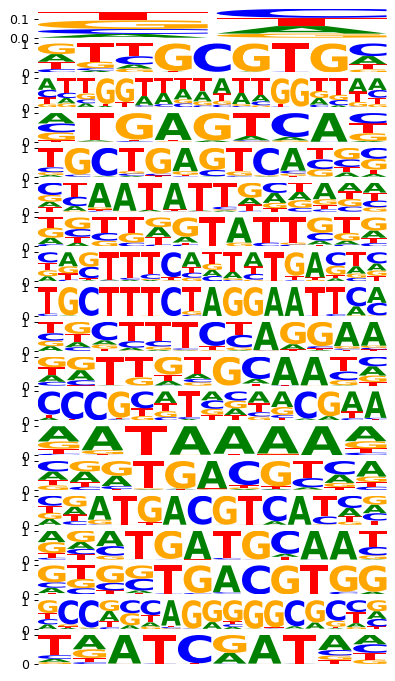

In [239]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([106,  41,  53, 249, 265,  27,  99, 231, 253, 156, 243, 114, 174,  49,
       165, 166, 122,  18, 274, 230],
      dtype='int64')
0 out of 288...
10 out of 288...


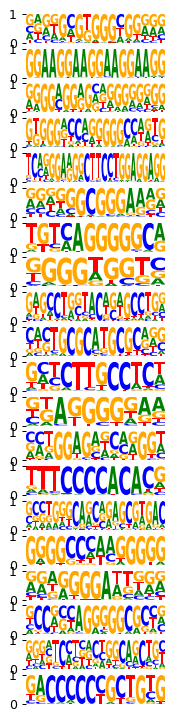

<Figure size 180x1800 with 0 Axes>

In [240]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [241]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 5.21084


In [242]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [243]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [244]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [245]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [246]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [247]:


print('association between motif activities and related TF targets ')
res = []
print(len(all_targets))

rna_sel_df = rna_sel.to_df()

for optimize_log_dynamic in model_by_logdynamic:
    print('use GraphLayer = %i' % optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 30 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
            assert gex.shape[1] == 1
            gex = gex.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))
            
res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

# p-values
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

# p-val adjust
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

association between motif activities and related TF targets 
155
use GraphLayer = 0
0
30
60
90
120
150
180
210
240
270
use GraphLayer = 1
0
30
60
90
120
150
180
210
240
270


,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
17,51,False,52,Nfil3,True,0.147914,1.390427e-02,CCAAT/CEBP,7.668416e-02
21,58,False,59,Hes1,True,-0.243880,4.217164e-05,Ebox/CACGTG/2,7.309751e-04
23,61,False,62,Neurod2,True,0.392554,1.328428e-11,Ebox/CATATG,4.835478e-09
24,65,False,66,Scrt1,True,0.250947,2.466831e-05,SCRT1,4.988481e-04
25,67,False,68,Id4,True,-0.188842,1.624649e-03,Ebox/CACCTG,1.579688e-02
...,...,...,...,...,...,...,...,...,...
333,247,True,248,Smarcd3,True,0.145444,1.559761e-02,NR/20,7.996522e-02
357,247,True,248,Arhgap20,True,-0.251112,2.435713e-05,NR/20,4.988481e-04
358,248,True,249,Hsf2,True,0.143942,1.671294e-02,HSF,8.449318e-02
361,272,True,273,Zic2,True,-0.148630,1.344463e-02,ZIC,7.668416e-02


In [248]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [249]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
23,61,False,62,Neurod2,True,0.392554,1.328428e-11,Ebox/CATATG,4.835478e-09
150,188,False,189,Nfix,True,0.336962,9.389615e-09,NFI/1,1.708910e-06
81,69,False,70,Tagln3,True,0.329529,2.057557e-08,TBX/1,2.496502e-06
98,69,False,70,Sptbn2,True,0.322971,4.040974e-08,TBX/1,3.677286e-06
49,69,False,70,Stmn1,True,0.314395,9.537784e-08,TBX/1,6.943507e-06
...,...,...,...,...,...,...,...,...,...
135,88,False,89,Sox6,True,0.003699,9.512271e-01,SOX/1,9.681593e-01
73,69,False,70,Ltbp1,True,-0.003019,9.601799e-01,TBX/1,9.681593e-01
258,69,True,70,Rtp4,True,0.001037,9.863132e-01,TBX/1,9.890303e-01
302,69,True,70,Ctsz,True,-0.001073,9.858398e-01,TBX/1,9.890303e-01


In [250]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [251]:
df2

opt_log_dynamic,False,True
k,,
Abracl_70,0.244488,0.113820
Acot1_32,-0.128086,0.082354
Acot1_41,-0.128086,0.082354
Acot1_70,-0.128086,0.082354
Adamts1_70,-0.014530,0.072233
...,...,...
Zbtb38_70,0.113146,0.089271
Zfp536_257,0.056228,0.031314
Zic1_110,-0.046562,-0.239629


In [252]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [253]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [254]:
# res['arch_name'] = name_by_filter_id

In [255]:
res

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
0,1,False,2,Dlx5,True,0.000654,0.991370,HD/2,0.991370,Dlx5_2
1,1,False,2,Tsen15,True,-0.082914,0.169573,HD/2,0.363361,Tsen15_2
2,1,False,2,Lhx2,True,0.091830,0.128037,HD/2,0.346899,Lhx2_2
3,6,False,7,Tsen15,True,-0.082914,0.169573,HD/7,0.363361,Tsen15_7
4,11,False,12,Pbx3,True,-0.089229,0.139248,HD/12,0.346899,Pbx3_12
...,...,...,...,...,...,...,...,...,...,...
359,256,True,257,Zfp536,True,0.031314,0.604460,P53-like/1,0.758701,Zfp536_257
360,261,True,262,Gli3,True,0.097580,0.105742,GLI,0.315995,Gli3_262
361,272,True,273,Zic2,True,-0.148630,0.013445,ZIC,0.076684,Zic2_273
362,272,True,273,Zic1,True,-0.239629,0.000058,ZIC,0.000876,Zic1_273


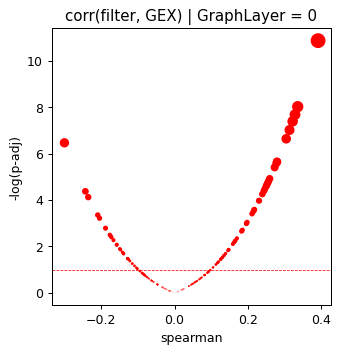

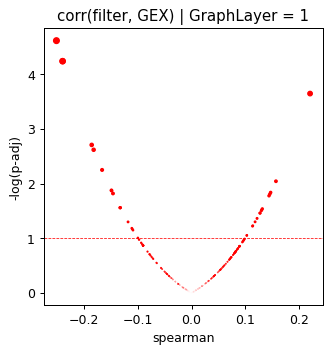

In [256]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 2), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

In [257]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

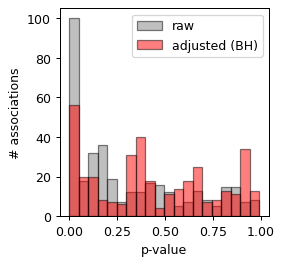

In [258]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [259]:
res[res['p_adj'] < 0.05]

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
21,58,False,59,Hes1,True,-0.243880,4.217164e-05,Ebox/CACGTG/2,7.309751e-04,Hes1_59
23,61,False,62,Neurod2,True,0.392554,1.328428e-11,Ebox/CATATG,4.835478e-09,Neurod2_62
24,65,False,66,Scrt1,True,0.250947,2.466831e-05,SCRT1,4.988481e-04,Scrt1_66
25,67,False,68,Id4,True,-0.188842,1.624649e-03,Ebox/CACCTG,1.579688e-02,Id4_68
29,69,False,70,Sult4a1,True,0.185675,1.950630e-03,TBX/1,1.785931e-02,Sult4a1_70
32,69,False,70,Ctss,True,-0.188585,1.649125e-03,TBX/1,1.579688e-02,Ctss_70
33,69,False,70,Tmsb10,True,0.184443,2.092861e-03,TBX/1,1.800361e-02,Tmsb10_70
34,69,False,70,Ctxn1,True,0.196325,1.042673e-03,TBX/1,1.054258e-02,Ctxn1_70
41,69,False,70,Kctd13,True,0.254737,1.838290e-05,TBX/1,4.779554e-04,Kctd13_70
44,69,False,70,Shtn1,True,0.163416,6.511015e-03,TBX/1,4.309108e-02,Shtn1_70


In [260]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [261]:
log_act = ad.obsm['log_activities'].copy()

In [262]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [263]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

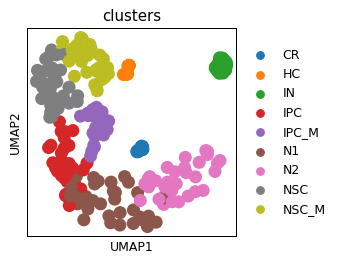

In [264]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [265]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

IPC_M
NSC_M
CR
IPC
HC
IN
N2
NSC
N1


,names,scores,logfoldchanges,pvals,pvals_adj,clusters,module_name
0,MBD2,3.155475,NaN,0.003289,0.040953,IPC_M,MBD2
1,NR/16,3.093564,NaN,0.003918,0.040953,IPC_M,NR/16
2,P53-like/1,3.037337,NaN,0.004518,0.040953,IPC_M,P53-like/1
3,ZNF85_0,3.006341,NaN,0.004892,0.040953,IPC_M,ZNF85_0
4,HD/12,2.997869,NaN,0.004854,0.040953,IPC_M,HD/12


Get top modules

In [266]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [267]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

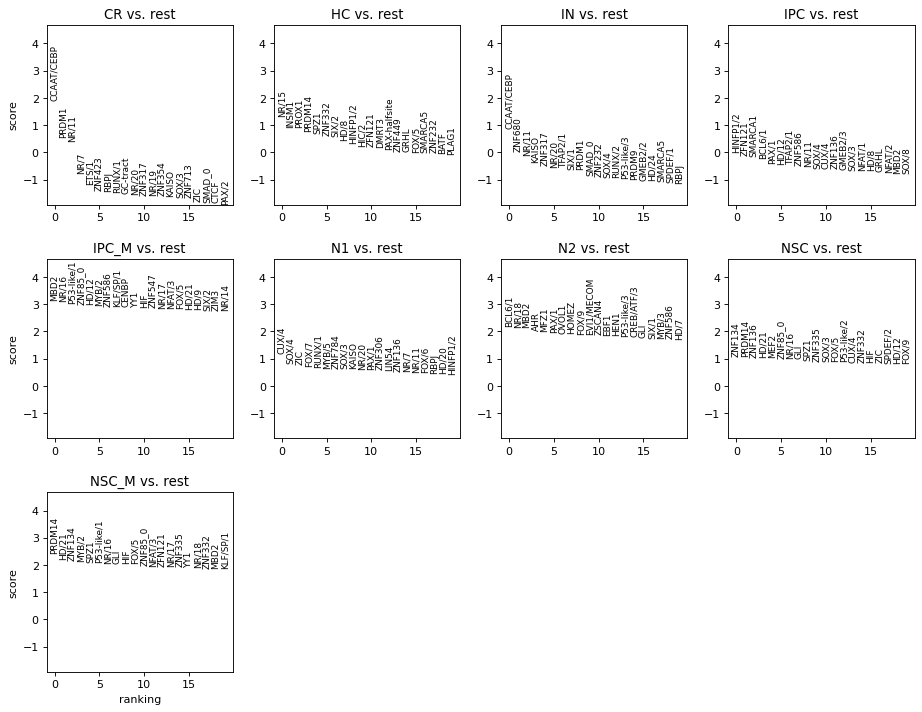

In [268]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [269]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Neurod2_62', 'Nfix_189', 'Sptbn2_70', 'Stmn1_70', 'Tagln3_70'}

In [270]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
2,1,False,2,Lhx2,True,0.091830,0.128037,HD/2,0.346899,Lhx2_2
4,11,False,12,Pbx3,True,-0.089229,0.139248,HD/12,0.346899,Pbx3_12
3,6,False,7,Tsen15,True,-0.082914,0.169573,HD/7,0.363361,Tsen15_7
1,1,False,2,Tsen15,True,-0.082914,0.169573,HD/2,0.363361,Tsen15_2
182,1,True,2,Dlx5,True,-0.078098,0.195821,HD/2,0.384385,Dlx5_2
184,1,True,2,Lhx2,True,0.063660,0.291940,HD/2,0.501255,Lhx2_2
183,1,True,2,Tsen15,True,0.040959,0.497989,HD/2,0.666426,Tsen15_2
185,6,True,7,Tsen15,True,0.040959,0.497989,HD/7,0.666426,Tsen15_7
186,11,True,12,Pbx3,True,-0.010556,0.861413,HD/12,0.920833,Pbx3_12
0,1,False,2,Dlx5,True,0.000654,0.991370,HD/2,0.991370,Dlx5_2


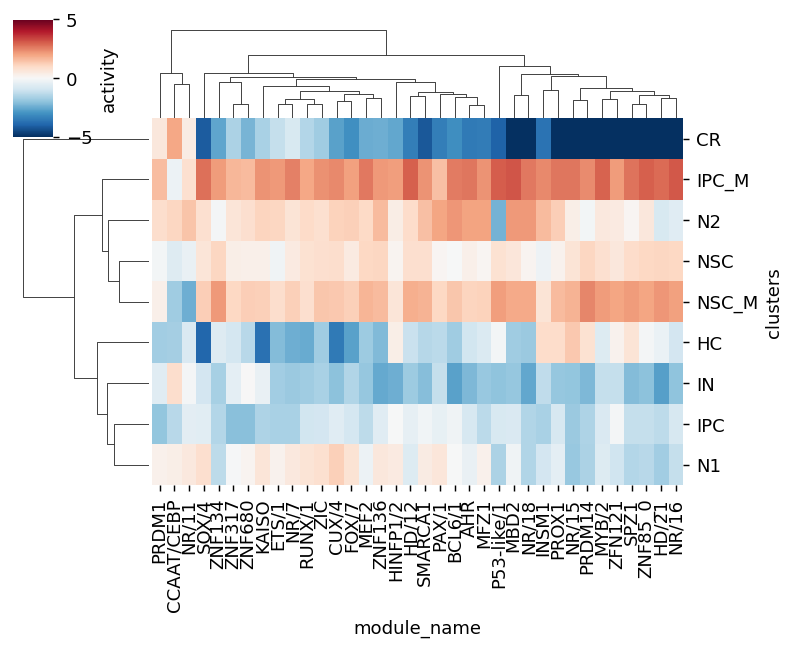

In [271]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               vmin=-5, vmax=5,
               figsize=[6.2, 5],
               # dpi=100,
               xticklabels=True)


In [272]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [273]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [274]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

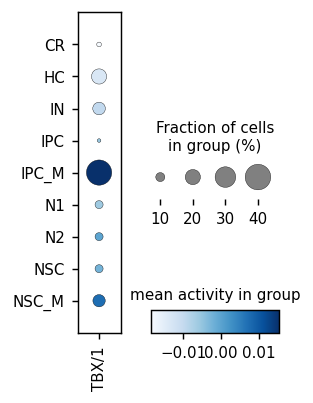

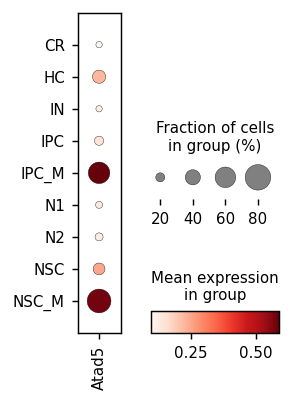

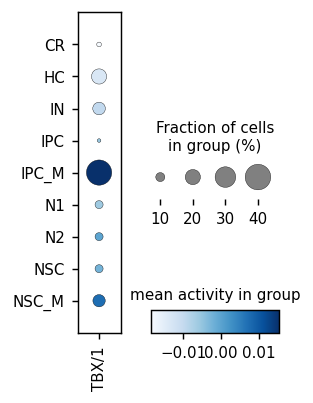

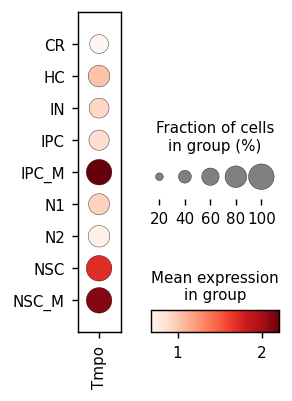

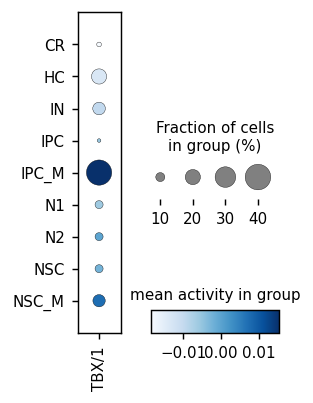

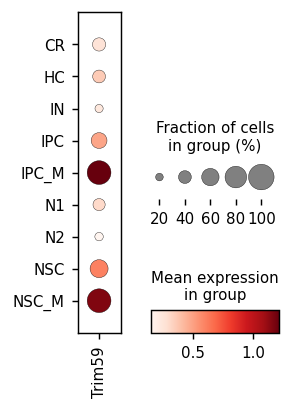

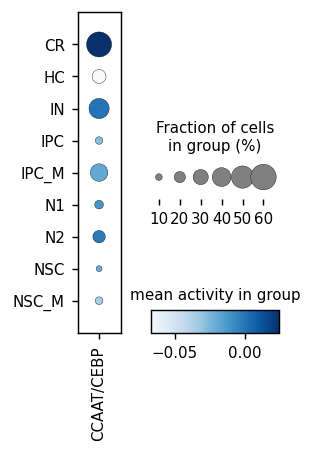

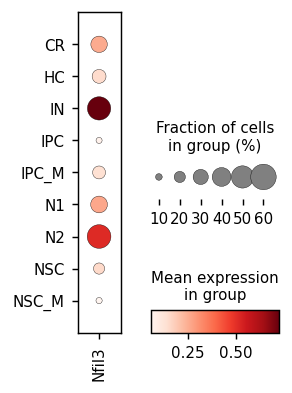

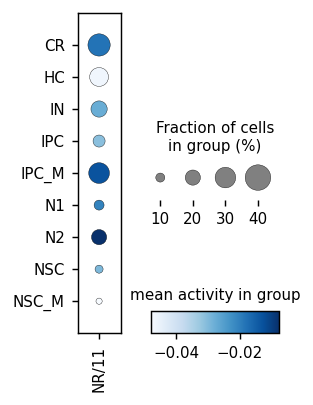

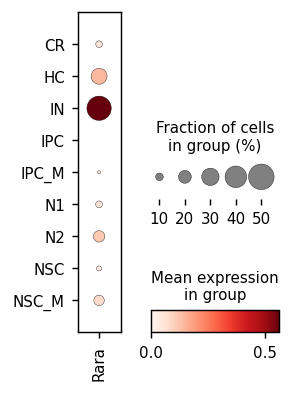

In [275]:

for ri, r in corr.sort_values('p_val').groupby('cell_type').head(3).iterrows():
    # ad_act.obs['HD/2'] = log_act['HD/2']
    sc.pl.dotplot(ad_act,
                groupby=cell_type_key,
                cmap='Blues',
                var_names=r['module_name'],
                figsize=[2, 3.2],
                colorbar_title='mean activity in group')
    sc.pl.dotplot(rna_sel,
                  groupby=cell_type_key,
                  var_names=r['gene_name'],
                  figsize=[2, 3.2])

In [276]:
### attempt to show together

for key_interaction in varm_ligrec_by_k:
    # if not 'Resident' in key_interaction:
    #     continue
    
    viz = varm_ligrec_by_k[key_interaction]
        
    obs = viz[['group']]
    obs['k2'] = obs.index.str.replace('index_', '').str.replace('neighbor', '') + '_' + obs['group']
    viz = anndata.AnnData(viz[viz.columns[1:]], obs=obs)


    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    from matplotlib import colors
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    plt.rcParams['figure.dpi'] = 150
    SMALL_SIZE = 14
    MEDIUM_SIZE = 19
    BIGGER_SIZE = 21
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    viz_df = viz.to_df()
    print(viz_df.shape)

    viz_df.index = viz.obs['k2']
    z = viz_df.copy()
    for c in z:
        z[c] = (z[c] - z[c].mean()) / z[c].std()

    tree_genes_2 = viz_df.idxmax(axis=1).to_dict()

    tree_genes = {}
    for k in tree_genes_2:
        tree_genes[k] = set([tree_genes_2[k]])

    z = z.T
    tree_genes = {}
    n = 3
    for c in z:
        tree_genes[c] = set(z.sort_values(c, ascending=False).index[:n])
    tree_genes

    diagonal_rectangle_heights = { k: 1 for k in tree_genes}
    #     'AT1'                                  :2,
    #     'AT2'                                  :2,
    #     'Club'                                 :2,
    #     'Multiciliated'                        :2,
    #     'Deuterosomal'                         :2,
    # #    'Basal'                                :2,
    # #    'Smooth muscle'                        :2,
    # #    'Pericytes'                            :2,
    # #    'Adventitial Fibroblast'               :1,
    # #    'Alveolar Fibroblast'                  :2,
    # #    '(Vascular) Endothelial cell'          :2,
    # #    'Cappillary (G) endothelial cell'      :2,
    # #    'Cappillary Aerocyte endothelial cell' :1,
    # #    'Lymphatic EC'                         :1,    
    #     'Lymphocyte'                           :2,
    # #    'DC'                                   :1,
    # #   'Monocytes'                            :1,
    # #    'Alv Macrophage'                       :2,
    #     'Interstitial macrophages'             :2,
    #     'Mast cells'                           :2,
    # }

    dot_color_df = viz_df # [list(set(g for k in tree_genes for g in tree_genes[k]))]
    # dot_color_df[dot_color_df < 0] = -dot_color_df[dot_color_df < 0]
    # dot_color_df.index = viz.obs_names

    sc_ct_list = [k for k in set(viz.obs['k2']) if 'immune' in k]
    ST_ct_list_with_space = [k for k in set(viz.obs['k2']) if 'tumor' in k]

    genes_by_group = {}
    for ri, r in cellphone_interactions.iterrows():
        # print(r)
        a, b = str(r['protein_name_a']).split('_')[0], str(r['protein_name_b']).split('_')[0]

        found_a = False
        found_b = False
        for ct in tree_genes:
            if a in tree_genes[ct]:
                found_a = True
            if b in tree_genes[ct]:
                found_b = True

        key_class = ' '.join(str(r['classification']).split(' ')[2:])
        if key_class == '':
            key_class = 'Others'
        # print(key_class)

        if a != 'nan' and found_a:
            if not key_class in genes_by_group:
                genes_by_group[key_class] = set()
            genes_by_group[key_class].add(a)
        if b != 'nan' and found_b:
            if not key_class in genes_by_group:
                genes_by_group[key_class] = set()
            genes_by_group[key_class].add(b)
        # if a in cpdb_names or b in cpdb_names:


    ## remove duplicates and empty
    order = [v for g in genes_by_group for v in genes_by_group[g]]
    order = list(dict.fromkeys(order))
    # order
    found_genes = set()
    for g in genes_by_group:
        values_group = [v for v in genes_by_group[g]]
        for v in values_group:
            if not v in found_genes:
                found_genes.add(v)
            else:
                genes_by_group[g].remove(v)

    # remove empty gruops
    key_groups = list(genes_by_group.keys())
    for g in key_groups:
        if len(genes_by_group[g]) == 0:
            del genes_by_group[g]

    fig = plt.figure(figsize=(10,5),
                    dpi=150)
    ax = plt.gca()

    reduced_tree_genes = {ct: tree_genes[ct] for ct in diagonal_rectangle_heights}

    print(viz.shape, dot_color_df.shape)
    # one can add arbitrary names
    # reduced_tree_genes['hello'] = reduced_tree_genes['AngiogenicTAMs:_MES2like2_immune']

    vmax = 0.2
    dp = sc.pl.DotPlot(viz,
                    genes_by_group, # reduced_tree_genes,
                    groupby="k2",
                    ax=ax,cmap="bwr",
                    vmin=-vmax,vmax=vmax,
                    var_group_rotation=90, # var_group_positions='ha',
                    dot_color_df=dot_color_df)
                    # standard_scale='var')

    # dp.dot_max = .9
    # dp.dot_min = 0.01
    # dp.smallest_dot=.15
    dp.make_figure()

    # assuming no duplicates, this is the matrix to inspect pairs.
    data = dot_color_df[[v for g in genes_by_group for v in genes_by_group[g]]]

    x_coord = 0

    thr_max = .1
    thr_diff = .1
    diffs = []
    for ci, c in enumerate(data):
        for i in range(0, len(data[c]), 2):
            a, b = data[c][i], data[c][i + 1]
            diffs.append([c, a, b, abs(a - b)])
            if abs(a - b) > thr_diff and abs(max(a, b)) > thr_max and (a > 0 or b > 0):
                print(c, a, b)
                rect = patches.Rectangle((ci, i), 1, 2,
                                        linewidth=2,
                                        linestyle='--',
                                        edgecolor='green',
                                        facecolor='none')#, zorder=1)
                dp.ax_dict["mainplot_ax"].add_patch(rect)

    for ct,height in diagonal_rectangle_heights.items():
        break
        print(ct, height)
        y = dot_color_df.index.get_loc(ct)
        width = len(tree_genes[ct])
        if height != 0:
            rect = patches.Rectangle((x_coord, y), width, height, linewidth=1, edgecolor='black', facecolor='none')#, zorder=1)
            dp.ax_dict["mainplot_ax"].add_patch(rect)
        x_coord += width
        

    old_ytick_labels = dp.ax_dict["mainplot_ax"].get_yticklabels()
    new_ticks = []
    yshift = 0
    for i, lab in enumerate(old_ytick_labels):
        # print(lab)
        x, y = lab.get_position()
        old_text = lab._text
        if lab._text in sc_ct_list:
            lab._text = '_'.join(lab._text.split('_')[:2]) + ' ' + lab._text.split('_')[-1]
            lab.set_color('purple')
            lab.set_x(x)
            lab.set_y(y + yshift)
            # print(x, y)
            new_ticks.append(y + yshift)
        elif lab._text in ST_ct_list_with_space:
            lab._text = old_text.split('_')[-1]
            lab.set_color('green')
            new_ticks.append(y + yshift)
        old_ytick_labels[i] = lab

    # print(old_ytick_labels)
    dp.ax_dict["mainplot_ax"].set_yticklabels(old_ytick_labels)
    print(dp.ax_dict["mainplot_ax"].get_yticklabels())
    print(dp.ax_dict["mainplot_ax"].set_yticks(new_ticks))
    print(dp.ax_dict["mainplot_ax"].get_yticks())


    # plt.show()
    # fig.savefig("./dotplot_sc_and_ST.png", bbox_inches = "tight")

    # break


NameError: name 'varm_ligrec_by_k' is not defined

In [ ]:
sc.pl.umap(rna_sel, color='Isl1', cmap='Blues')


: 

In [ ]:
ad_act

: 

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

: 

In [ ]:
cmap

: 

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)


: 